In [1]:
import pandas as pd
import urllib

website = 'http://cycling.data.tfl.gov.uk/usage-stats/'
csv_list = [
    '01aJourneyDataExtract10Jan16-23Jan16.csv', 
    '01b Journey Data Extract 24Jan16-06Feb16.csv']

url_list = [website + urllib.parse.quote(ul) for ul in csv_list]
dfs = (pd.read_csv(url) for url in url_list)
dfs_data = pd.concat(dfs, ignore_index=True)

dfs_data = dfs_data[dfs_data['EndStation Id'] != dfs_data['StartStation Id']]

print(dfs_data.shape)
dfs_data.head()

(563606, 9)


,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,50754225,240,11834,10/01/2016 00:04,383.0,"Frith Street, Soho",10/01/2016 00:00,18,"Drury Lane, Covent Garden"
1,50754226,300,9648,10/01/2016 00:05,719.0,"Victoria Park Road, Hackney Central",10/01/2016 00:00,479,"Pott Street, Bethnal Green"
2,50754227,1200,10689,10/01/2016 00:20,272.0,"Baylis Road, Waterloo",10/01/2016 00:00,425,"Harrington Square 2, Camden Town"
3,50754228,780,8593,10/01/2016 00:14,471.0,"Hewison Street, Old Ford",10/01/2016 00:01,487,"Canton Street, Poplar"
4,50754229,600,8619,10/01/2016 00:11,399.0,"Brick Lane Market, Shoreditch",10/01/2016 00:01,501,"Cephas Street, Bethnal Green"


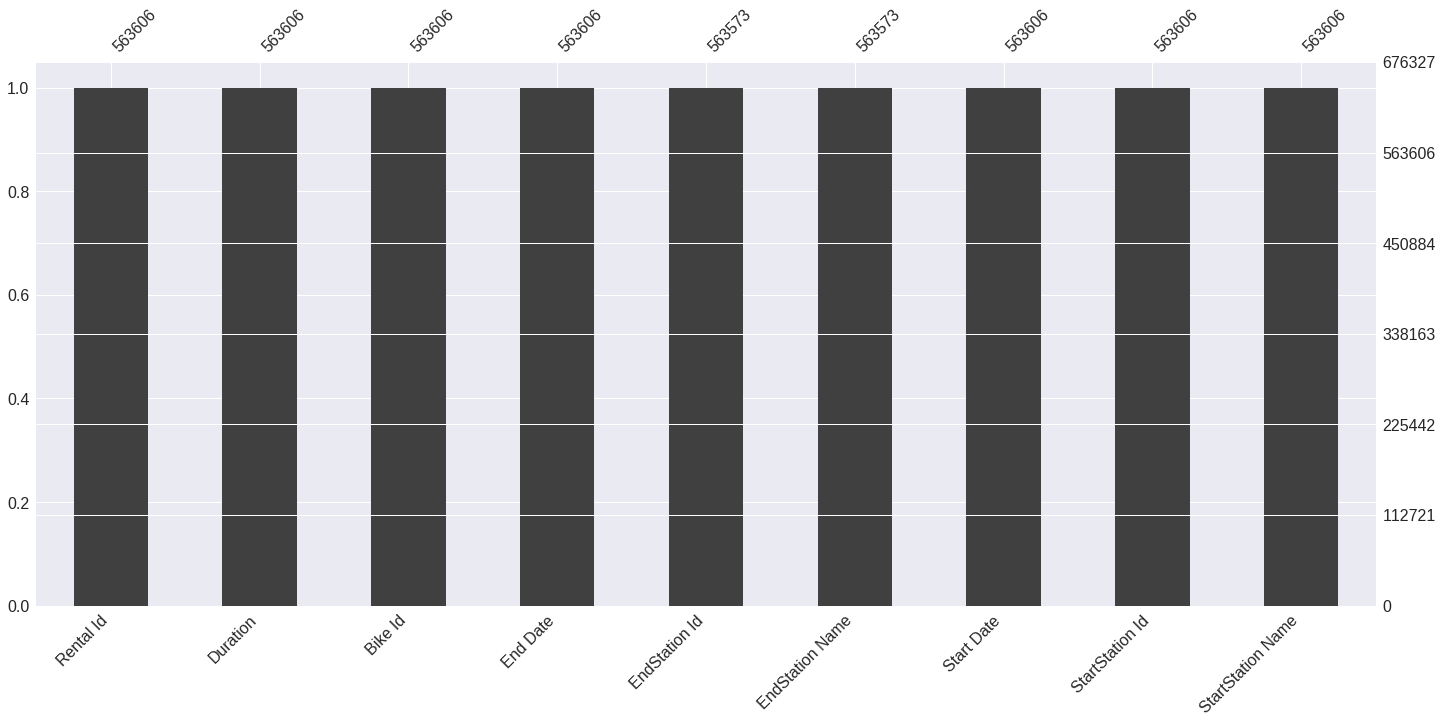

In [2]:
# Visualise missing -> none, charlie maybe your regex missed some IDs?
import missingno as msno
%matplotlib inline
msno.bar(dfs_data)

In [3]:
df_loc_data = pd.read_json("https://api.tfl.gov.uk/bikepoint", orient='values')
df_loc_data = df_loc_data[['commonName', 'id', 'lat', 'lon']]
df_loc_data['id'] = df_loc_data['id'].apply(lambda x: int(x.split('_')[-1]))

print(df_loc_data.shape)
df_loc_data.head()

(771, 4)


,commonName,id,lat,lon
0,"River Street , Clerkenwell",1,51.529163,-0.109970
1,"Phillimore Gardens, Kensington",2,51.499606,-0.197574
2,"Christopher Street, Liverpool Street",3,51.521283,-0.084605
3,"St. Chad's Street, King's Cross",4,51.530059,-0.120973
4,"Sedding Street, Sloane Square",5,51.493130,-0.156876


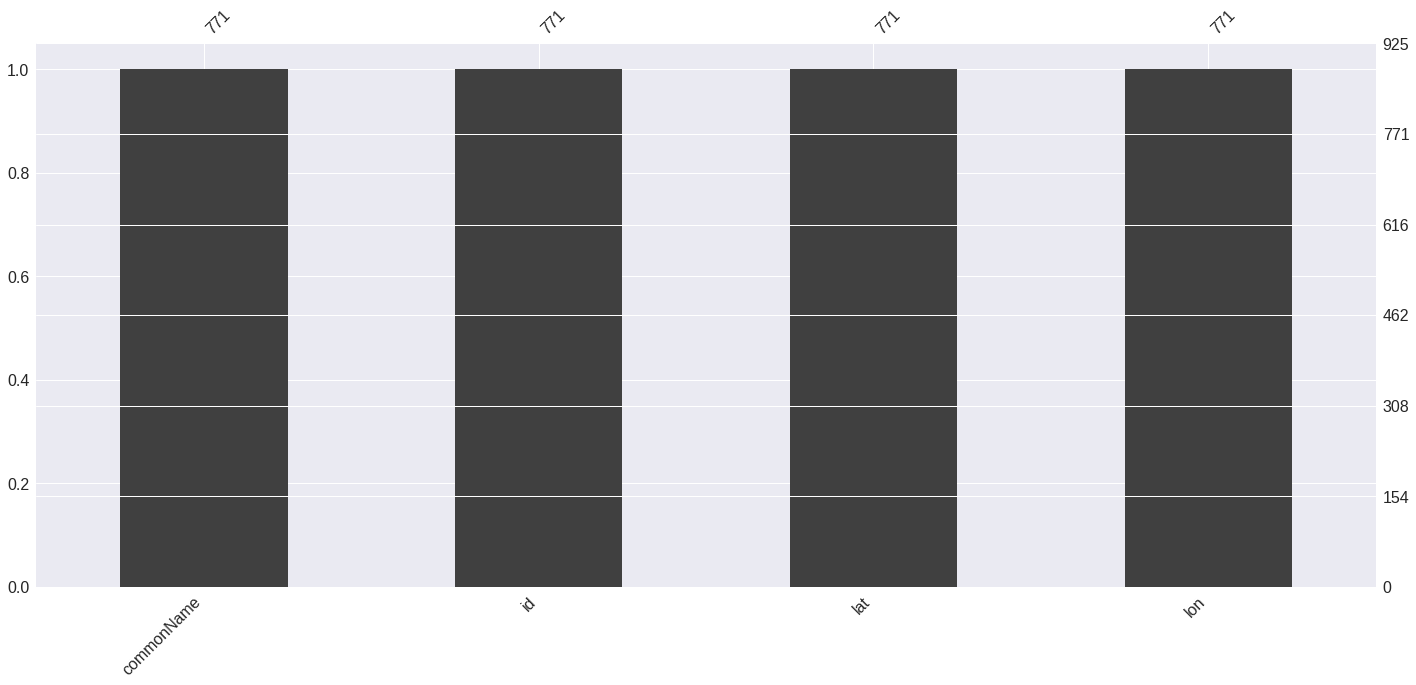

In [4]:
msno.bar(df_loc_data)

In [5]:
# Merge start
merge_start = dfs_data.merge(right = df_loc_data,
                             how = 'inner',
                             left_on = 'StartStation Id',
                             right_on = 'id')

merge_start.drop(labels = ["id", "commonName"], axis=1, inplace=True)
merge_start.rename(columns={'lat': 'StartStation lat', 'lon': 'StartStation lon'},
                   inplace=True)
# Merge end
merge_end = merge_start.merge(right = df_loc_data,
                             how = 'inner',
                             left_on = 'EndStation Id',
                             right_on = 'id')

merge_end.drop(labels = ["id", "commonName"], axis=1, inplace=True)
merge_end.rename(columns={'lat': 'EndStation lat', 'lon': 'EndStation lon'},
                   inplace=True)

merge_end.head(2)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,StartStation lat,StartStation lon,EndStation lat,EndStation lon
0,50754225,240,11834,10/01/2016 00:04,383.0,"Frith Street, Soho",10/01/2016 00:00,18,"Drury Lane, Covent Garden",51.51477,-0.122219,51.513103,-0.131213
1,51096336,240,3356,25/01/2016 20:56,383.0,"Frith Street, Soho",25/01/2016 20:52,18,"Drury Lane, Covent Garden",51.51477,-0.122219,51.513103,-0.131213


In [6]:
list(merge_end.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Id',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name',
 'StartStation lat',
 'StartStation lon',
 'EndStation lat',
 'EndStation lon']

In [7]:
unq_locs = merge_end[['StartStation Id',
                      'StartStation lat',
                      'StartStation lon',
                      'EndStation Id',
                      'EndStation lat',
                      'EndStation lon']]
print(unq_locs.shape)
unq_locs.drop_duplicates(inplace=True)
print(unq_locs.shape)

(537672, 6)
(121298, 6)


/home/iliauk/.conda/envs/pythree/lib/python3.5/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [8]:
# Submit route request to Ubuntu Server running OSRM
# Asychronously generate 500 requests at a time

In [9]:
import aiohttp
import asyncio
import json
concurrent = 500

In [10]:
def CreateUrl(row):
    sid, slat, slon, eid, elon, elat = row
    base_url = "http://osmrouting.uksouth.cloudapp.azure.com/"
    route_url = "osrm/route/v1/bicycle/{0},{1};{2},{3}".format(slon, slat, elon, elat)
    end_url = "?alternatives=false&steps=false&geometries=geojson"
    return base_url+route_url+end_url, '%i_%i' % (sid, eid)

url_list = unq_locs.apply(func=CreateUrl, axis=1)
print(len(url_list))

121298


In [11]:
def handle_req(data, qid):
    r = json.loads(data.decode('utf-8'))
    coord = r['routes'][0]['geometry']['coordinates']
        
    dffrom = pd.DataFrame(coord[:-1], columns=['slon', 'slat'])
    dfto = pd.DataFrame(coord[1:], columns=['elon', 'elat'])
    df_journey = pd.concat([dffrom, dfto], axis=1)
    df_journey['route_id'] = qid

    return df_journey
 
def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect
    # locking of semaphore
    def http_get(url, qid):
        nonlocal semaphore
        with (yield from semaphore):
            response = yield from s.get(url)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body, qid
    return http_get
 
def run_experiment(urls, _session):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)
    
    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url, qid) for url, qid in urls]
    
    dfs_route = []
    
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data, qid = yield from future
        try:
            out = handle_req(data, qid)
            dfs_route.append(out)
        except Exception as err:
            print("Error for {0} - {1}".format(qid, err))
    return dfs_route

In [12]:
# Run:
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    calc_routes = loop.run_until_complete(run_experiment(url_list, session))

Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7f9ee47cf4e0>


In [52]:
routes_complete = pd.concat(calc_routes, ignore_index=True)

In [53]:
print(routes_complete.shape)
routes_complete.head()

(1302174, 5)


,slon,slat,elon,elat,route_id
0,-0.123701,51.506757,-0.550657,51.264435,354_583
1,-0.550657,51.264435,-0.704022,51.094319,354_583
2,-0.704022,51.094319,-0.917865,51.026138,354_583
3,-0.917865,51.026138,-1.113862,50.807071,354_583
4,-1.113862,50.807071,-1.043196,50.685613,354_583


In [54]:
# Merge segments onto routes and collapse by count
agg_routes = pd.DataFrame(
    merge_end[['StartStation Id', 'EndStation Id']].apply(
        func=lambda x: "%i_%i" % (x[0], x[1]),
        axis=1),
    columns = ['route_id'])

agg_routes.head()

,route_id
0,18_383
1,18_383
2,18_383
3,425_383
4,717_383


In [55]:
agg_routes['c'] = 1
count_routes = agg_routes.groupby(['route_id']).sum()
count_routes.reset_index(inplace=True)

print(count_routes.shape)
count_routes.head()

(121298, 2)


,route_id,c
0,100_101,3
1,100_104,1
2,100_108,9
3,100_11,2
4,100_112,1


In [56]:
routes = count_routes.merge(right = routes_complete, how='inner', on='route_id')
routes.to_csv('counted_segments_to_plot.csv', header=True, index=None)
print(routes.shape)
routes.head()

(1302174, 6)


,route_id,c,slon,slat,elon,elat
0,100_101,3,-0.122587,51.490397,-0.550657,51.264435
1,100_101,3,-0.550657,51.264435,-0.704022,51.094319
2,100_101,3,-0.704022,51.094319,-0.917865,51.026138
3,100_101,3,-0.917865,51.026138,-1.113862,50.807071
4,100_101,3,-1.113862,50.807071,-1.043196,50.685613


In [ ]:
# Ready to plot (slon, slat) to (elon, elat)
# Weighted by c